In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set environment variables
import os

os.environ["SCAL_TYPE"] = "complex"
os.environ["PRECISION"] = "double"
os.environ["MY_NUMBA_TARGET"] = "numba"
 
# Add cle_fun to PYTHON_PATH
import sys
sys.path.append("../../clonscal")

In [2]:
from src.utils import RollingStats, get_rolling_stats_scal_kernel, update_rolling_stats_scal_kernel
from src.numba_target import my_act_parallel_loop, my_parallel_loop


Using double precision
Using C^1
Using Numba


In [3]:
from simulation.cl_simulation import ComplexLangevinSimulation
from simulation.config import Config
from src.obs_kernels import n_moment_kernel

config = Config(dims = [1], trajs = int(2), dt = 0.04, ada_step = True,mass_real = 1, interaction=2)
sim = ComplexLangevinSimulation(config)

sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_param={'order': 1}, langevin_history=True, thermal_time=3, auto_corr=0.1)
sim.register_observable('2_moment', obs_kernel=n_moment_kernel, const_param={'order': 2}, langevin_history=True, thermal_time=3, auto_corr=0.1)

In [4]:
for _ in range(int(100)):
    sim.step()
    tracker = sim.trackers['1_moment']
    tracker.mark_equilibrated_trajs()
    tracker.compute()

    tracker = sim.trackers['2_moment']
    tracker.mark_equilibrated_trajs()
    tracker.compute()
sim.finish()
sim.langevin_steps

100

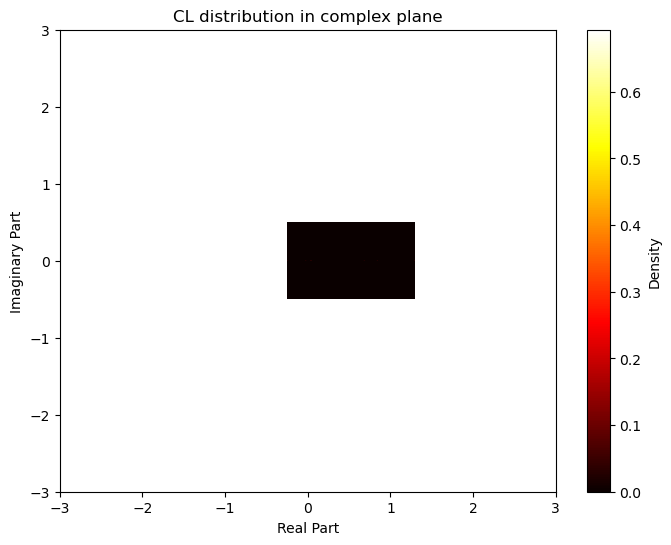

In [5]:
data = sim.trackers['1_moment'].history

magnitudes = np.abs(data)
data = data[magnitudes <= 10]   
real_parts, imag_parts = data.real, data.imag
bins = 500
heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(
    np.log(heatmap+1).T,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    origin='lower',
    cmap='hot',
    aspect='auto'
)

plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.colorbar(label='Density')
plt.title('CL distribution in complex plane')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(visible=False)
plt.show()